In [1]:
# Importar bibliotecas necessárias
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Função principal
def process_transaction_graph(file_path):
    """
    Processa e visualiza um grafo de transações com destaque para fraudes.
    :param file_path: Caminho para o arquivo CSV de transações.
    """
    # Carregar o CSV
    try:
        df = pd.read_csv(file_path)
        print("Arquivo carregado com sucesso!")
    except FileNotFoundError:
        print(f"O arquivo {file_path} não foi encontrado. Verifique o caminho e tente novamente.")
        return
    
    # Verificar se as colunas esperadas existem no arquivo
    expected_columns = ['TX_ID', 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', 
                        'TX_TYPE', 'TX_AMOUNT', 'TIMESTAMP', 'IS_FRAUD']
    if not all(col in df.columns for col in expected_columns):
        print(f"O arquivo CSV deve conter as colunas: {', '.join(expected_columns)}")
        return
    
    # Criar o grafo orientado (DiGraph)
    G = nx.DiGraph()
    for _, row in df.iterrows():
        G.add_edge(
            row['SENDER_ACCOUNT_ID'], 
            row['RECEIVER_ACCOUNT_ID'], 
            tx_id=row['TX_ID'], 
            tx_type=row['TX_TYPE'], 
            tx_amount=row['TX_AMOUNT'], 
            timestamp=row['TIMESTAMP'], 
            is_fraud=row['IS_FRAUD']
        )

    print(f"Grafo criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")

    # Identificar arestas fraudulentas
    edge_colors = []
    edge_widths = []

    for u, v, d in G.edges(data=True):
        if d['is_fraud'] == 1:
            edge_colors.append('red')  # Transações fraudulentas em vermelho
            edge_widths.append(2.5)    # Arestas fraudulentas mais espessas
        else:
            edge_colors.append('gray')  # Transações normais em cinza
            edge_widths.append(1.0)     # Arestas normais mais finas

    # Identificar nós e verificar se eles estão conectados a fraudes
    node_colors = []
    node_sizes = []

    for node in G.nodes():
        fraud_edges = any(G[u][v]['is_fraud'] == 1 for u, v in G.edges(node))
        if fraud_edges:
            node_colors.append('red')  # Nó associado a fraudes
            node_sizes.append(500)     # Maior tamanho para nós fraudulentos
        else:
            node_colors.append('lightblue')  # Nós normais
            node_sizes.append(300)           # Tamanho padrão

    # Layout geral e visualização
    plt.figure(figsize=(50, 25))
    pos = nx.kamada_kawai_layout(G, scale=200)  # Melhor distribuição para grafos complexos

    # Desenho do grafo
    nx.draw(
        G, pos,
        with_labels=True,
        node_size=node_sizes,
        node_color=node_colors,
        edge_color=edge_colors,
        width=edge_widths,
        font_size=10,
        alpha=0.8
    )

    plt.title("Grafo de Transações com Destaque para Fraudes")
    plt.show()

# Caminho para o arquivo CSV
file_path = "./data/1k/transactions.csv"

# Chamar a função principal
process_transaction_graph(file_path)


Arquivo carregado com sucesso!
Grafo criado com 1000 nós e 5891 arestas.


KeyboardInterrupt: 

<Figure size 5000x2500 with 0 Axes>

Arquivo carregado com sucesso!
Grafo criado com 1000 nós e 5891 arestas.
Subgrafo de Fraudes: 119 nós e 114 arestas.


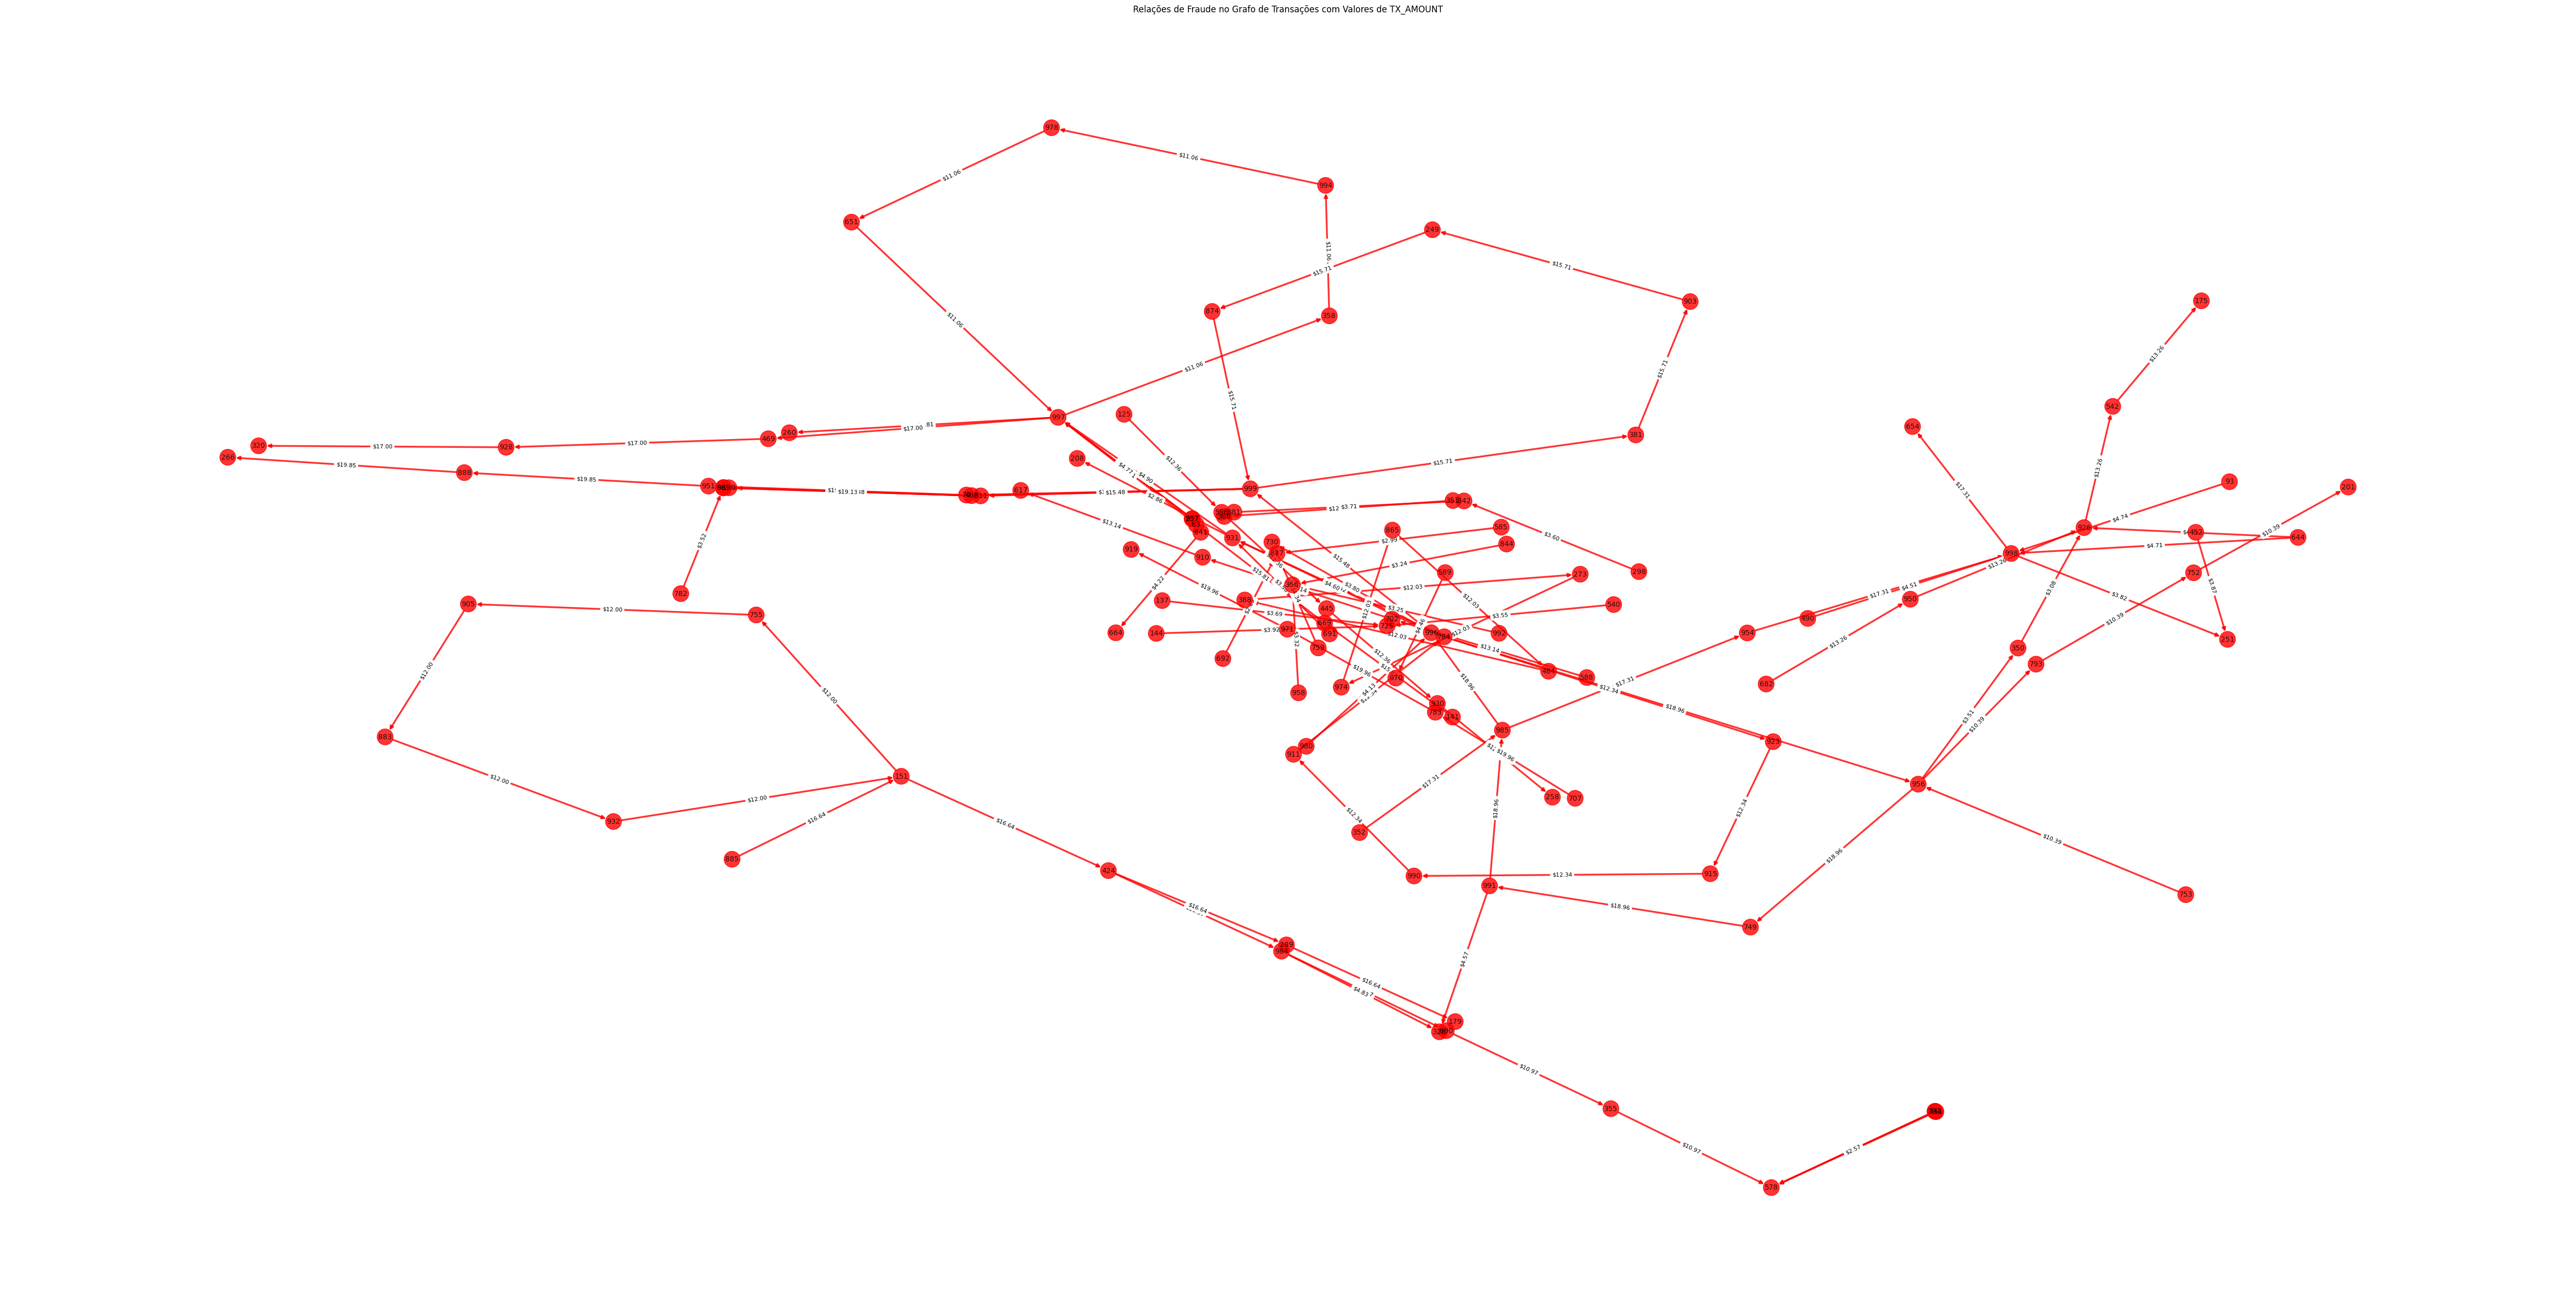

In [22]:
def show_fraud_only_graph_with_amount(file_path):
    """
    Filtra e exibe apenas as relações (arestas e nós) que possuem a condição de fraude no grafo,
    mostrando o valor `TX_AMOUNT` nas arestas.
    :param file_path: Caminho para o arquivo CSV de transações.
    """
    # Carregar o CSV
    try:
        df = pd.read_csv(file_path)
        print("Arquivo carregado com sucesso!")
    except FileNotFoundError:
        print(f"O arquivo {file_path} não foi encontrado. Verifique o caminho e tente novamente.")
        return
    
    # Verificar se as colunas esperadas existem no arquivo
    expected_columns = ['TX_ID', 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', 
                        'TX_TYPE', 'TX_AMOUNT', 'TIMESTAMP', 'IS_FRAUD']
    if not all(col in df.columns for col in expected_columns):
        print(f"O arquivo CSV deve conter as colunas: {', '.join(expected_columns)}")
        return

    # Criar o grafo orientado (DiGraph)
    G = nx.DiGraph()
    for _, row in df.iterrows():
        G.add_edge(
            row['SENDER_ACCOUNT_ID'], 
            row['RECEIVER_ACCOUNT_ID'], 
            tx_id=row['TX_ID'], 
            tx_type=row['TX_TYPE'], 
            tx_amount=row['TX_AMOUNT'], 
            timestamp=row['TIMESTAMP'], 
            is_fraud=row['IS_FRAUD']
        )

    print(f"Grafo criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")

    # Criar subgrafo contendo apenas as arestas fraudulentas
    fraud_edges = [(u, v) for u, v, d in G.edges(data=True) if d['is_fraud'] == 1]
    fraud_graph = G.edge_subgraph(fraud_edges).copy()

    print(f"Subgrafo de Fraudes: {fraud_graph.number_of_nodes()} nós e {fraud_graph.number_of_edges()} arestas.")

    # Configuração visual para o subgrafo
    edge_colors = ['red' for _ in fraud_graph.edges()]
    edge_widths = [2.5 for _ in fraud_graph.edges()]
    node_colors = ['red' for _ in fraud_graph.nodes()]
    node_sizes = [500 for _ in fraud_graph.nodes()]

    # Obter labels para as arestas (valor do amount)
    edge_labels = {(u, v): f"${d['tx_amount']:.2f}" for u, v, d in fraud_graph.edges(data=True)}

    # Layout e visualização (com escala para espaçar mais os nós)
    plt.figure(figsize=(50, 25))
    pos = nx.kamada_kawai_layout(fraud_graph, scale=200)  # Escala ajustada para espaçar os nós

    # Desenho do subgrafo
    nx.draw(
        fraud_graph, pos,
        with_labels=True,
        node_size=node_sizes,
        node_color=node_colors,
        edge_color=edge_colors,
        width=edge_widths,
        font_size=10,
        alpha=0.8
    )

    # Adicionar labels às arestas
    nx.draw_networkx_edge_labels(fraud_graph, pos, edge_labels=edge_labels, font_size=8, font_color='black')

    plt.title("Relações de Fraude no Grafo de Transações com Valores de TX_AMOUNT")
    plt.show()

# Chamar a função para exibir apenas as fraudes com valores de TX_AMOUNT
show_fraud_only_graph_with_amount(file_path)


In [23]:
import os

def save_fraud_graphs(file_path, output_dir):
    """
    Gera e salva imagens de subgrafos separados com fraudes detectadas.
    :param file_path: Caminho para o arquivo CSV de transações.
    :param output_dir: Diretório onde as imagens serão salvas.
    """
    # Criar diretório de saída, se não existir
    os.makedirs(output_dir, exist_ok=True)

    # Carregar o CSV
    try:
        df = pd.read_csv(file_path)
        print("Arquivo carregado com sucesso!")
    except FileNotFoundError:
        print(f"O arquivo {file_path} não foi encontrado. Verifique o caminho e tente novamente.")
        return
    
    # Verificar se as colunas esperadas existem no arquivo
    expected_columns = ['TX_ID', 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', 
                        'TX_TYPE', 'TX_AMOUNT', 'TIMESTAMP', 'IS_FRAUD']
    if not all(col in df.columns for col in expected_columns):
        print(f"O arquivo CSV deve conter as colunas: {', '.join(expected_columns)}")
        return

    # Criar o grafo orientado (DiGraph)
    G = nx.DiGraph()
    for _, row in df.iterrows():
        G.add_edge(
            row['SENDER_ACCOUNT_ID'], 
            row['RECEIVER_ACCOUNT_ID'], 
            tx_id=row['TX_ID'], 
            tx_type=row['TX_TYPE'], 
            tx_amount=row['TX_AMOUNT'], 
            timestamp=row['TIMESTAMP'], 
            is_fraud=row['IS_FRAUD']
        )

    # Filtrar arestas fraudulentas
    fraud_edges = [(u, v) for u, v, d in G.edges(data=True) if d['is_fraud'] == 1]
    fraud_graph = G.edge_subgraph(fraud_edges).copy()

    # Conectar componentes e salvar imagens de cada subgrafo
    connected_components = list(nx.weakly_connected_components(fraud_graph))
    print(f"Identificados {len(connected_components)} subgrafos com fraudes.")

    for i, component in enumerate(connected_components, start=1):
        subgraph = fraud_graph.subgraph(component).copy()

        # Configuração visual para o subgrafo
        edge_colors = ['red' for _ in subgraph.edges()]
        edge_widths = [2.5 for _ in subgraph.edges()]
        node_colors = ['red' for _ in subgraph.nodes()]
        node_sizes = [500 for _ in subgraph.nodes()]
        
        # Obter labels para as arestas (valor do amount)
        edge_labels = {(u, v): f"${d['tx_amount']:.2f}" for u, v, d in subgraph.edges(data=True)}

        # Layout e visualização (com escala ajustada para espaçar os nós)
        plt.figure(figsize=(20, 15))
        pos = nx.kamada_kawai_layout(subgraph, scale=200)

        nx.draw(
            subgraph, pos,
            with_labels=True,
            node_size=node_sizes,
            node_color=node_colors,
            edge_color=edge_colors,
            width=edge_widths,
            font_size=10,
            alpha=0.8
        )
        nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8, font_color='black')

        # Salvar imagem
        output_file = os.path.join(output_dir, f"fraud_subgraph_{i}.png")
        plt.title(f"Subgrafo de Fraude {i}")
        plt.savefig(output_file, format='png')
        plt.close()
        print(f"Imagem do subgrafo {i} salva em: {output_file}")

# Caminho para o arquivo CSV
file_path = "./data/1k/transactions.csv"

# Diretório para salvar as imagens
output_dir = "./fraud_graphs"

# Gerar e salvar os subgrafos fraudulentos
save_fraud_graphs(file_path, output_dir)


Arquivo carregado com sucesso!
Identificados 12 subgrafos com fraudes.
Imagem do subgrafo 1 salva em: ./fraud_graphs/fraud_subgraph_1.png
Imagem do subgrafo 2 salva em: ./fraud_graphs/fraud_subgraph_2.png
Imagem do subgrafo 3 salva em: ./fraud_graphs/fraud_subgraph_3.png
Imagem do subgrafo 4 salva em: ./fraud_graphs/fraud_subgraph_4.png
Imagem do subgrafo 5 salva em: ./fraud_graphs/fraud_subgraph_5.png
Imagem do subgrafo 6 salva em: ./fraud_graphs/fraud_subgraph_6.png
Imagem do subgrafo 7 salva em: ./fraud_graphs/fraud_subgraph_7.png
Imagem do subgrafo 8 salva em: ./fraud_graphs/fraud_subgraph_8.png
Imagem do subgrafo 9 salva em: ./fraud_graphs/fraud_subgraph_9.png
Imagem do subgrafo 10 salva em: ./fraud_graphs/fraud_subgraph_10.png
Imagem do subgrafo 11 salva em: ./fraud_graphs/fraud_subgraph_11.png
Imagem do subgrafo 12 salva em: ./fraud_graphs/fraud_subgraph_12.png


In [27]:
pip install spektral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 12.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import tensorflow as tf
from spektral.layers import GCNConv
from spektral.data import Graph
from spektral.data import Dataset, BatchLoader

# Carregar o CSV
file_path = "./data/1k/transactions.csv"
df = pd.read_csv(file_path)

# Criar o grafo usando NetworkX
G = nx.DiGraph()
for _, row in df.iterrows():
    G.add_edge(
        row['SENDER_ACCOUNT_ID'], 
        row['RECEIVER_ACCOUNT_ID'], 
        tx_id=row['TX_ID'], 
        tx_type=row['TX_TYPE'], 
        tx_amount=row['TX_AMOUNT'], 
        timestamp=row['TIMESTAMP'], 
        is_fraud=row['IS_FRAUD']
    )

# Mapear IDs de nós para índices
node_mapping = {node: i for i, node in enumerate(G.nodes())}
num_nodes = len(node_mapping)

# Criar matrizes de adjacência e características
adjacency_matrix = nx.to_numpy_array(G, nodelist=node_mapping.keys())
features = np.eye(num_nodes)  # Características iniciais (exemplo: one-hot encoding)
labels = np.zeros(num_nodes)  # Inicializar os rótulos
for u, v, data in G.edges(data=True):
    if data['is_fraud'] == 1:
        labels[node_mapping[u]] = 1
        labels[node_mapping[v]] = 1

# Dividir os dados em treino e teste
train_mask = np.random.rand(num_nodes) < 0.8  # 80% dos dados para treino
test_mask = ~train_mask                       # 20% dos dados para teste

# Normalizar a matriz de adjacência
degree_matrix = np.diag(np.sum(adjacency_matrix, axis=1))
laplacian = degree_matrix - adjacency_matrix
adjacency_matrix = adjacency_matrix + np.eye(num_nodes)  # Self-loops
degree_inv_sqrt = np.linalg.inv(np.sqrt(degree_matrix))
normalized_adjacency = degree_inv_sqrt @ adjacency_matrix @ degree_inv_sqrt

# Criar o dataset no formato Spektral
class FraudDataset(Dataset):
    def read(self):
        return [
            Graph(
                x=features,
                a=normalized_adjacency,
                y=labels
            )
        ]

dataset = FraudDataset()
loader = BatchLoader(dataset, batch_size=1)

# Modelo GCN
class GCN(tf.keras.Model):
    def __init__(self, n_hidden, n_classes):
        super().__init__()
        self.conv1 = GCNConv(n_hidden, activation="relu")
        self.conv2 = GCNConv(n_classes, activation="softmax")

    def call(self, inputs):
        x, a = inputs
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        return x

# Instanciar o modelo
model = GCN(n_hidden=16, n_classes=2)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Treinamento adaptado
for batch in loader:
    graph = batch  # O loader retorna um único grafo por iteração
    x, a, y = graph[0].x, graph[0].a, graph[0].y
    x_train, y_train = x[train_mask], y[train_mask]
    x_test, y_test = x[test_mask], y[test_mask]

    # Ajustar o modelo no conjunto de treino
    history = model.fit(
        [x_train, a],
        y_train,
        validation_data=([x_test, a], y_test),
        batch_size=32,
        epochs=100
    )

# Avaliação final
loss, accuracy = model.evaluate([x_test, normalized_adjacency], labels[test_mask])
print(f"Loss: {loss}, Accuracy: {accuracy}")


2024-11-25 01:42:37.970198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-25 01:42:38.935855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-25 01:42:38.936176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-25 01:42:38.942443: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

AttributeError: 'tuple' object has no attribute 'x'

In [ ]:
# Salvar o modelo no formato SavedModel
model.save("model/grafo/grafo_model")

# Ou salvar no formato HDF5
model.save("model/grafo/grafo.h5")